## Try to reuse the model

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
#!pip install -q tensorflow-gpu==2.0.0-beta1
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from tqdm import tqdm


#  Model save and reuse..

In [2]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:
  PATH = os.path.abspath('.')+'/train2014/'
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 200000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
print(len(train_captions)+len(all_captions))


614113


In [3]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)
image_features_extract_model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, None, None, 6 192         conv2d_19[0][0]                  
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, None, None, 6 192         conv2d_21[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, None, None, 9 288         conv2d_24[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 6 192         conv2d_25[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, None, None, 6 0           batch_normalization_19[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_40 (BatchNo (None, None, None, 1 576         conv2d_40[0][0]                  
__________________________________________________________________________________________________
batch_normalization_43 (BatchNo (None, None, None, 1 576         conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_48 (BatchNo (None, None, None, 1 576         conv2d_48[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
activation_40 (Activation)      (None, None, None, 1 0           batch_normalization_40[0][0]     
__________

batch_normalization_73 (BatchNo (None, None, None, 1 576         conv2d_73[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, None, None, 1 0           batch_normalization_73[0][0]     
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_74 (Conv2D)              (None, None, None, 1 258048      activation_73[0][0]              
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, None, None, 1 576         conv2d_70[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_1[0][0]              
                                                                 activation_93[0][0]              
Total params: 21,802,784
Trainable params: 21,768,352
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [4]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

top_k=12000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)
print(len(img_name_train)+ len(cap_train)+ len(img_name_val)+ len(cap_val))
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

400000


In [5]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
status=ckpt.restore(ckpt_manager.latest_checkpoint)


# 使用圖1~10做測試

Picture:1.jpg, Prediction Caption: a computer monitor sitting on a desk <end>


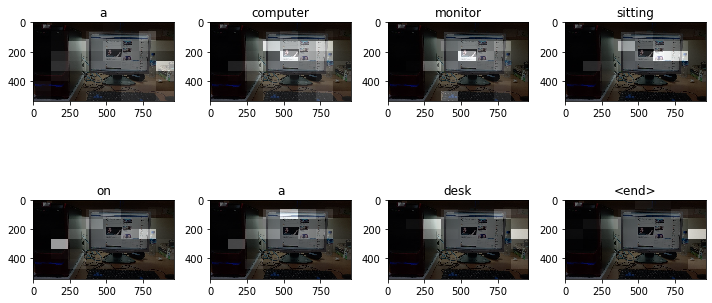

Picture:2.jpg, Prediction Caption: a cat is standing in a window <end>


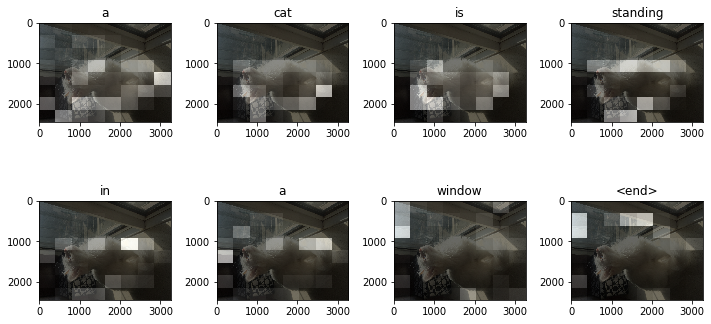

Picture:3.jpg, Prediction Caption: a little girl is holding a tennis racket <end>


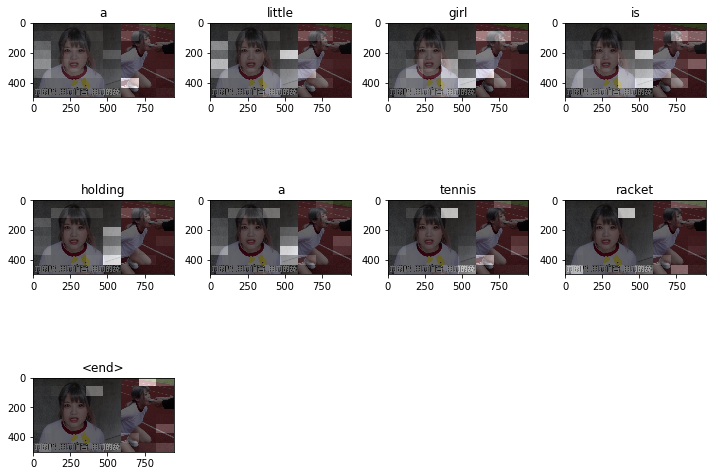

Picture:4.jpg, Prediction Caption: a bride and groom pose for a picture with a wedding cake
 <end>


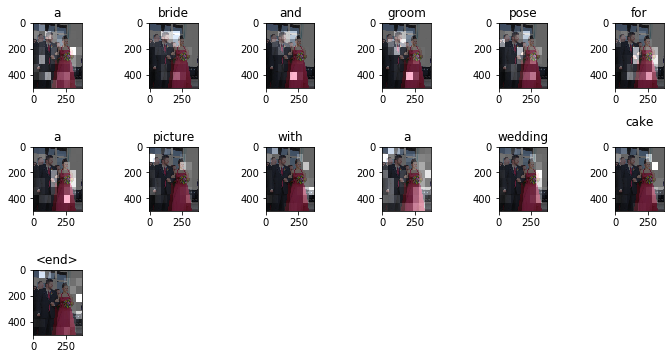

Picture:5.jpg, Prediction Caption: a group of people sitting in a living room with a suitcase <end>


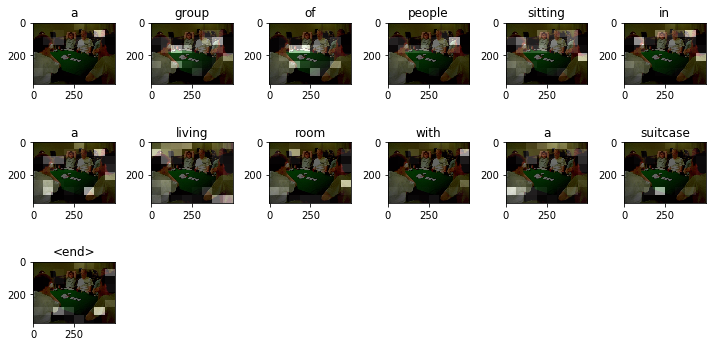

Picture:6.jpg, Prediction Caption: a little girl in a blue shirt sitting on a surfboard <end>


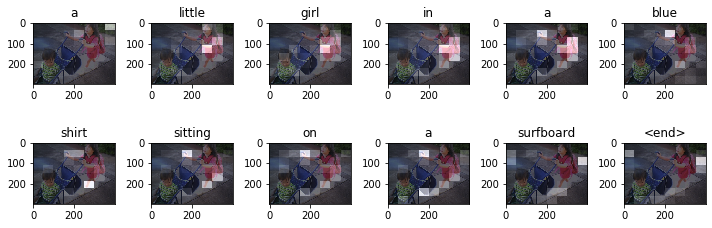

Picture:7.jpg, Prediction Caption: a group of people are standing in the foreground and a sign in the middle of a fence <end>


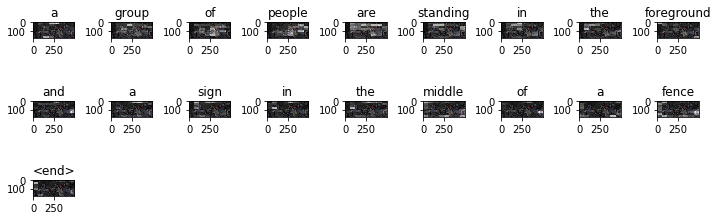

Picture:8.jpg, Prediction Caption: a man standing in front of a street <end>


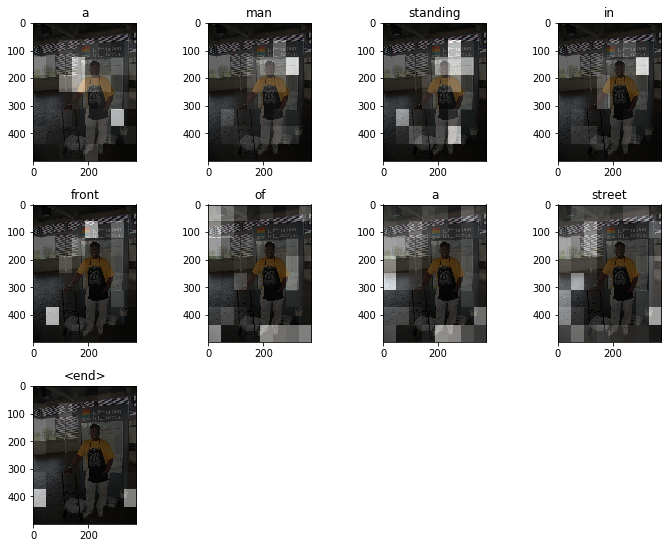

Picture:9.jpg, Prediction Caption: a group of people are playing a game of grass <end>


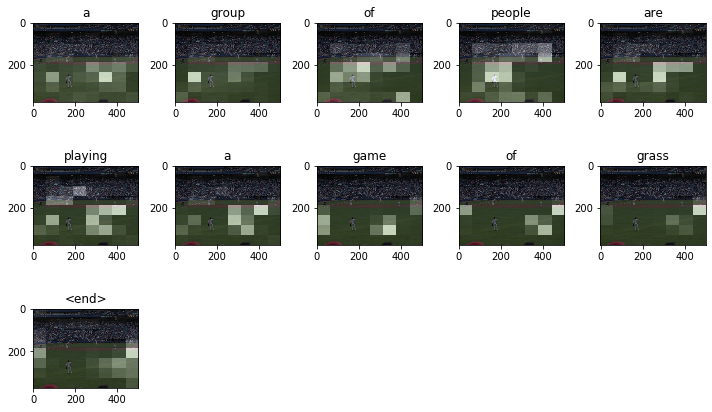

Picture:10.jpg, Prediction Caption: a large barn with a clock tower in the sky <end>


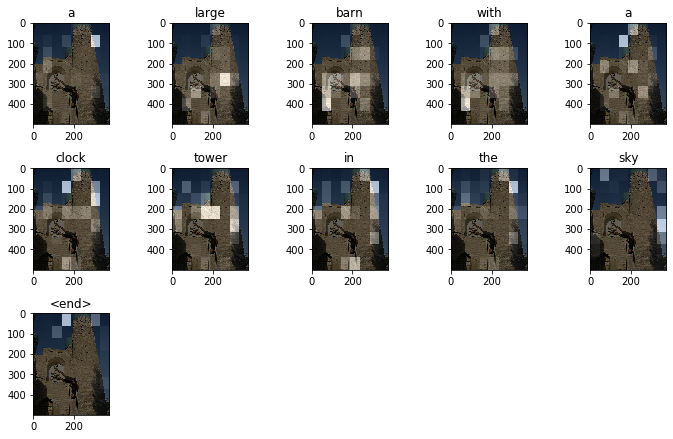

In [7]:
i=1
while i<=10:
    image_path = f'{i}.jpg'
    Image.open(image_path)
    result, attention_plot = evaluate(image_path)
    print (f'Picture:{image_path}'+', Prediction Caption:', ' '.join(result))
    plot_attention(image_path, result, attention_plot)
    # opening the image
    i+=1

## TRY ON YOUR OWN PIC

Picture:uuu.jpg, Prediction Caption: a man walking a dog sitting on a leash <end>


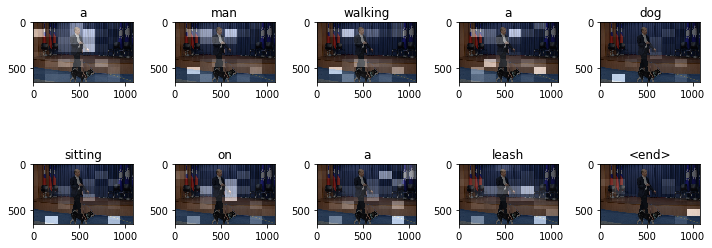

In [8]:
image_path = 'uuu.jpg'
Image.open(image_path)
result, attention_plot = evaluate(image_path)
print (f'Picture:{image_path}'+', Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
